### Single Portfolio Sorts
###### By Yuecheng Jia

###### 1. Data preparation

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import statsmodels.formula.api as smf
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators
import xgboost
from scipy.stats import chisquare, kendalltau

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

ModuleNotFoundError: No module named 'xgboost'

In [2]:
cd 

/Users/mm


1.1. Sample construction

In [3]:
exR = pd.read_csv("Exchange_rates.csv")
exR['Date'] = pd.to_datetime(exR['Date'],format="%Y-%m-%d")
fwdPRC1mo = exR.resample('M', on='Date', label='right').last()

In [4]:
fwdPRC1mo = fwdPRC1mo.set_index('Date', inplace = False)
del fwdPRC1mo['ARGENTINE PESO TO US $ 1M NDF (WMR) - EXCHANGE RATE']
del fwdPRC1mo['CHILEAN PESO TO US $ 1M NDF (WMR) - EXCHANGE RATE']
del fwdPRC1mo['COLOMBIAN PESO TO US $ 1M NDF (WMR) - EXCHANGE RATE']
countryIndex1 = list(fwdPRC1mo.columns)

In [5]:
sR = pd.read_csv("Spot_rates.csv")
sR['Date'] = pd.to_datetime(sR['Date'], format="%Y-%m-%d")
spotPRC1mo = sR.resample('M', on='Date', label='right').last()

In [6]:
spotPRC1mo = spotPRC1mo.set_index('Date', inplace = False)
del spotPRC1mo['ARGENTINE PESO TO US $ (WMR) - EXCHANGE RATE']
del spotPRC1mo['CHILEAN PESO TO US $ (WMR) - EXCHANGE RATE']
del spotPRC1mo['COLOMBIAN PESO TO US $ (WMR) - EXCHANGE RATE']
countryIndex2 = list(spotPRC1mo.columns)

In [7]:
(fwdPRC1mo.shape, spotPRC1mo.shape)

((306, 48), (306, 48))

In [8]:
fwdPrem = (fwdPRC1mo.values - spotPRC1mo.values)/spotPRC1mo.values
fwdPrem = pd.DataFrame(fwdPrem,columns = fwdPRC1mo.columns)

In [9]:
fwdSpot = spotPRC1mo.shift(-1)
exret = (fwdPRC1mo.values - fwdSpot.values)/spotPRC1mo.values
exret = pd.DataFrame(exret, columns = fwdPRC1mo.columns)
spotChange = (fwdSpot.values - spotPRC1mo.values)/spotPRC1mo.values
spotChange = pd.DataFrame(spotChange, columns = spotPRC1mo.columns)
fwdRet = spotPRC1mo.shift(-1)/spotPRC1mo-1
curRet = spotPRC1mo/spotPRC1mo.shift(-1)-1

In [10]:
(exret.shape, spotChange.shape, fwdRet.shape, curRet.shape)

((306, 48), (306, 48), (306, 48), (306, 48))

1.2. NaN transformation and standardization

In [11]:
def nanTransfer(tar):
    tar_ = np.zeros((tar.shape[0], tar.shape[1]))
    tar_indct = np.isnan(tar)
    for i in range(tar_.shape[0]):
        for j in range(tar_.shape[1]):
            if tar_indct[i, j] == True:
                tar_[i, j] = 0
            else:
                tar_[i, j] = tar[i, j]
    return tar_

In [12]:
def infTransfer(tar):
    tar_ = np.zeros((tar.shape[0], tar.shape[1]))
    tar_indct = np.isinf(tar)
    for i in range(tar_.shape[0]):
        for j in range(tar_.shape[1]):
            if tar_indct[i, j] == True:
                tar_[i, j] = 0
            else:
                tar_[i, j] = tar[i, j]
    return tar_

In [13]:
def standardizer(tar):
    import bottleneck as bn
    tar_ = np.zeros((tar.shape[0], tar.shape[1]))
    for i in range(tar_.shape[0]):
        minValue = min(tar[i, :])
        maxValue = max(tar[i, :])
        meanValue = bn.nanmean(tar[i, :])
        stdValue = bn.nanstd(tar[i, :])
        for j in range(tar_.shape[1]):
            tar_[i, j] = (tar[i, j] - minValue)/(maxValue - minValue)
            #tar_[i, j] = (tar[i, j]-meanValue)/stdValue
    return tar_

###### 2. LASSO model

In [14]:
def postLassoPred(windowLength, YY, XX):
    from sklearn.linear_model import LassoLarsCV
    warnings.filterwarnings("ignore")
    window = windowLength
    predvalues = np.zeros((YY.shape[0]-window+1, YY.shape[1]))
    
    for i in range(YY.shape[0]-window):
        if i%50 == 0:
            print("This is the round of %s: " %i)
        x = XX[i:i+window, :]
        y = YY[i:i+window, :]
        for j in range(YY.shape[1]):
            dep = y[:, j]
            indep1 = x[:, :j]
            indep2 = x[:, j+1:]
            indep = np.hstack([indep1, indep2])
            nrows, npreds = indep.shape
            #nows, nresps = dep.shape
            indep_shape = indep.shape[1]
            #print("The shape of indep is %s:" %indep_shape)
            # 0.00041 monthly developing country
            lasso = Lasso(alpha = 0.000021)
            #lasso = LassoLarsIC(criterion='aic')
            #lasso = LassoLarsCV(cv=3)
            model = lasso.fit(indep, dep)
            coef = model.coef_
            predcols = [i for i in range(npreds) if model.coef_[i] !=0]
            
            countnum = np.sum(coef)
            
            if countnum == 0:
                predvalues[i, j] = 0
            else:
                #coef_dict.append(predcols)
                # col nums of selected responses
                model_ols = LinearRegression()
                model_ols.fit(indep[:, predcols], dep)
                y_pred = model_ols.predict(indep[-1, predcols])
                predvalues[i, j] =  y_pred
    return predvalues

In [15]:
Y = exret.values
X = fwdPrem.values
Z = curRet.values

Y = pd.DataFrame(Y)
X = pd.DataFrame(X)
X_1 = X.shift(1)
X_2 = X.shift(2)
X_combo = np.hstack([Z, X])

Y = np.asarray(Y)
X = np.asarray(X)
X_combo = np.asarray(X_combo)

Y = np.asarray(Y)
X = np.asarray(X)
X_combo = np.asarray(X_combo)

In [16]:
Y_ = nanTransfer(Y)
X_ = nanTransfer(X)
X_combo_ = nanTransfer(X_combo)

Y__ = standardizer(Y_)
X__ = standardizer(X_)
X_combo__ = standardizer(X_combo_)

In [17]:
%%time
win = 50
predvalues_postlassoCT = postLassoPred(win, Y__, X__)

This is the round of 0: 
This is the round of 50: 
This is the round of 100: 
This is the round of 150: 
This is the round of 200: 
This is the round of 250: 
Wall time: 2min 58s


In [18]:
nanmatrix = np.zeros((win-1, Y__.shape[1]))
nanmatrix[:] = np.nan

In [19]:
predvalues_postlassoCT_ = np.vstack([nanmatrix, predvalues_postlassoCT])

###### 3. Single portfolio sorts

In [63]:
Y = pd.DataFrame(Y)
fwdY = Y.shift(-1)
fwdY = np.asarray(fwdY)
ct = fwdPrem.values

2.1. Portfolio Sorts

In [78]:
def SinglePortSort(quintile, XX, YY):
    import bottleneck as bn
    
    bottom = 1.0 / quintile
    top = 1 - bottom
    mid1 = 0.6
    mid2 = 0.4
    
    # get common data
    XX = np.where((~np.isnan(XX) & (~np.isnan(YY))), XX, np.nan)
    YY = np.where((~np.isnan(XX) & (~np.isnan(YY))), YY, np.nan)
    # cross-rank Y
    curRank = bn.nanrankdata(XX, axis=1)
    
    x_rk = curRank/bn.nanmax(curRank, axis=1)[:, np.newaxis]
    
    L = np.zeros((x_rk.shape[0], x_rk.shape[1]))
    S = np.zeros((x_rk.shape[0], x_rk.shape[1]))
    Q2 = np.zeros((x_rk.shape[0], x_rk.shape[1]))
    Q3 = np.zeros((x_rk.shape[0], x_rk.shape[1]))
    Q4 = np.zeros((x_rk.shape[0], x_rk.shape[1]))
    
    for i in range(x_rk.shape[0]):
        for j in range(x_rk.shape[1]):
            if x_rk[i, j]>top:
                L[i, j] = YY[i, j]
                S[i, j] = np.nan
                Q2[i, j] = np.nan
                Q3[i, j] = np.nan
                Q4[i, j] = np.nan
            elif x_rk[i, j] <=bottom:
                L[i, j] = np.nan
                S[i, j] = YY[i, j]
                Q2[i, j] = np.nan
                Q3[i, j] = np.nan
                Q4[i, j] = np.nan
            elif x_rk[i, j]>bottom and x_rk[i, j]<=mid2:
                L[i, j] = np.nan
                S[i, j] = np.nan
                Q2[i, j] = YY[i, j]
                Q3[i, j] = np.nan
                Q4[i, j] = np.nan
            elif x_rk[i, j]>mid2 and x_rk[i, j]<=mid1:
                L[i, j] = np.nan
                S[i, j] = np.nan
                Q2[i, j] = np.nan
                Q3[i, j] = YY[i, j]
                Q4[i, j] = np.nan
            else:
                L[i, j] = np.nan
                S[i, j] = np.nan
                Q2[i, j] = np.nan
                Q3[i, j] = np.nan
                Q4[i, j] = YY[i, j]
    
    L_m = np.nanmean(L,axis=1)[:, np.newaxis]
    S_m = np.nanmean(S,axis=1)[:, np.newaxis]
    Q2_m = np.nanmean(Q2,axis=1)[:, np.newaxis]
    Q3_m = np.nanmean(Q3,axis=1)[:, np.newaxis]
    Q4_m = np.nanmean(Q4,axis=1)[:, np.newaxis]
    
    QtlPort = np.hstack([S_m, Q2_m, Q3_m, Q4_m, L_m])
    a = ['S', 'Q2', 'Q3', 'Q4', 'L']
    QtlPort = pd.DataFrame(QtlPort, columns = a)
    return QtlPort

In [79]:
%%time
QtlPort  = SinglePortSort(5, predvalues_postlassoCT_, fwdY)

Wall time: 67 ms


2.2. Print Summary Statistics

In [85]:
QtlPort['LS'] = QtlPort['L'] - QtlPort['S']
LS = QtlPort['LS'].values
L = QtlPort['L'].values
S = QtlPort['S'].values
Q2 = QtlPort['Q2'].values
Q3 = QtlPort['Q3'].values
Q4 = QtlPort['Q4'].values

In [87]:
QtlPort.describe()

,S,Q2,Q3,Q4,L,LS
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,-0.005434,-0.000701,0.000601,0.000439,0.005078,0.010512
std,0.031794,0.022399,0.022917,0.023465,0.022741,0.029699
min,-0.158076,-0.134782,-0.109142,-0.094339,-0.105597,-0.086986
25%,-0.016628,-0.010829,-0.013322,-0.010354,-0.006639,-0.004519
50%,-0.001236,0.001618,0.001410,0.001350,0.006249,0.007752
75%,0.010324,0.010714,0.013298,0.012555,0.018468,0.022477
max,0.090969,0.069082,0.061204,0.078692,0.066803,0.153714


In [90]:
(0.010512/(0.029699/np.sqrt(255)),0.005078/(0.022741/np.sqrt(255)),0.000439/(0.023465/np.sqrt(255)),0.000601/(0.022917/np.sqrt(255)),\
 -0.000701/(0.022399/np.sqrt(255)), -0.005434/(0.031794/np.sqrt(255)))

(5.6521491825017955,
 3.5657691934534506,
 0.2987542223120693,
 0.418780834010798,
 -0.49975768182921515,
 -2.7292577638169435)

2.3. Bar charts for portfolios

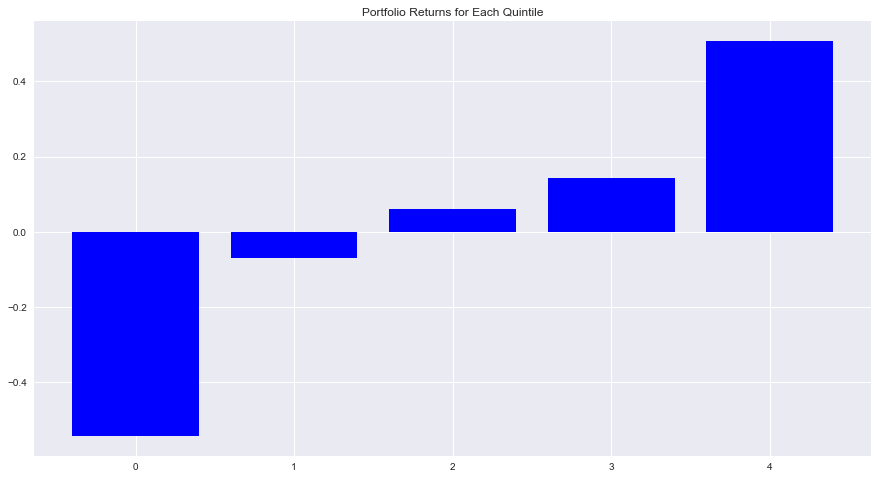

In [91]:
qtlStack = [-0.543,-0.071, 0.06, 0.144, 0.508]
plt.figure(figsize = (15, 8))
plt.title('Portfolio Returns for Each Quintile')
plt.bar(range(len(qtlStack)), qtlStack, fc='blue')
plt.show()

2.4. Time--series plot

In [94]:
a = fwdPRC1mo.index

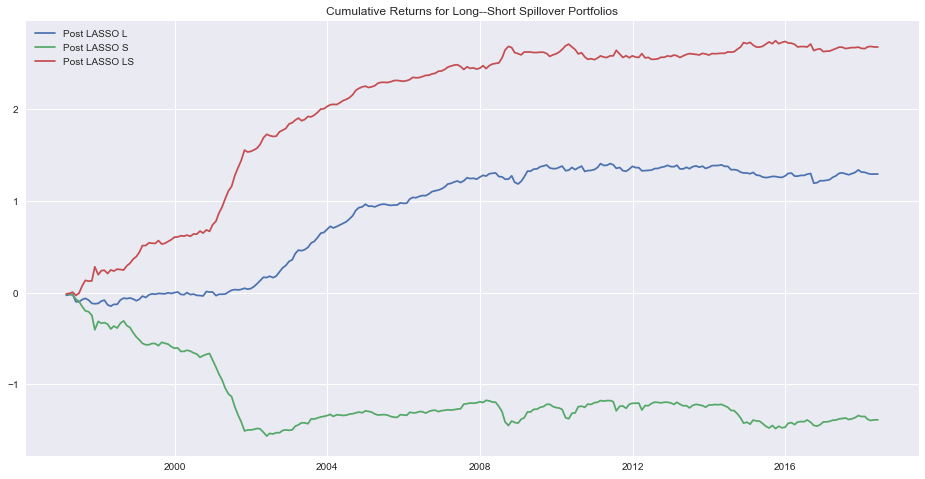

In [95]:
cumL = np.nancumsum(L)
cumS = np.nancumsum(S)
cumLS = np.nancumsum(LS)

cumL = pd.DataFrame(cumL)
cumL = cumL.set_index(a, inplace=False)
cumS = pd.DataFrame(cumS)
cumS = cumS.set_index(a, inplace=False)
cumLS = pd.DataFrame(cumLS)
cumLS = cumLS.set_index(a, inplace=False)

plt.figure(figsize = (16, 8))
plt.title("Cumulative Returns for Long--Short Spillover Portfolios")
plt.plot(cumL[49:], label = 'Post LASSO L')
plt.plot(cumS[49:], label = 'Post LASSO S')
plt.plot(cumLS[49:], label = 'Post LASSO LS')
plt.legend()
plt.show()

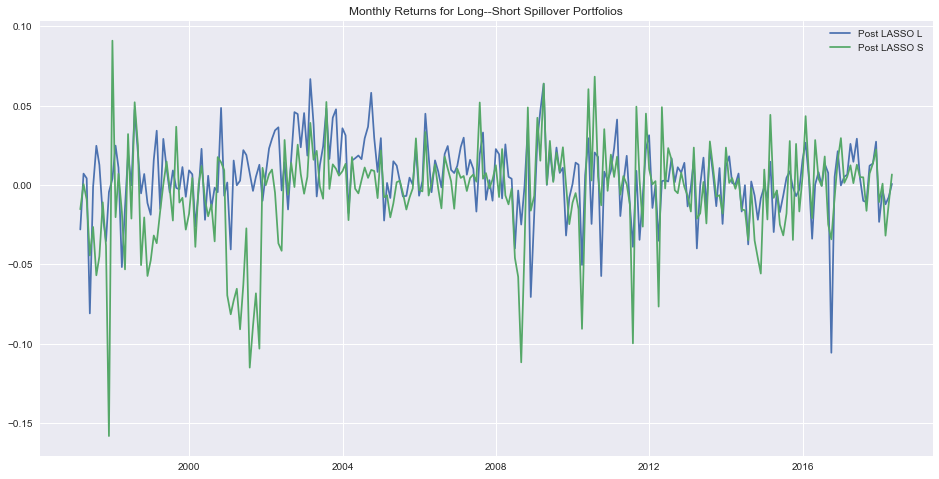

In [96]:
L = pd.DataFrame(L)
L = L.set_index(a, inplace=False)
S = pd.DataFrame(S)
S = S.set_index(a, inplace=False)
LS = pd.DataFrame(LS)
LS = LS.set_index(a, inplace=False)

plt.figure(figsize = (16, 8))
plt.title("Monthly Returns for Long--Short Spillover Portfolios")
plt.plot(L[49:], label = 'Post LASSO L')
plt.plot(S[49:], label = 'Post LASSO S')
plt.legend()
plt.show()